In [1]:
%matplotlib inline

In [2]:
import torchvision.models as models
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
import numpy as np
from PIL import Image
import copy
from IPython.display import clear_output
import sys
from IPython.display import display

In [3]:
mean=[0.485, 0.456, 0.406] 
std=[0.229, 0.224, 0.225]
trans = transforms.Compose([
            transforms.Normalize(mean, std)
        ])
    
def numpy2image(img_numpy):
    if img_numpy.dtype == np.dtype('float64'): #нужно домножить на 255 и поменять тип
        img_numpy = (img_numpy*255).astype('uint8')
    return Image.fromarray(img_numpy)

# [DeepDream](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
Используем тот же самый метод Gradient Ascent. Только в этом случае усиливаем действие не одного нейрона а всей группы на слое
1. Пропускаем картинку через сеть
2. Устанавливаем градиент выбранного слоя (не нейрона) равным их активации (dx=x)
3. Делаем backward
4. Обновляем картинку <br/>
В нашем случае функция, которую мы максимизируем
$$ I^* = arg max ( \sum_i f_i (I)^2) $$

Дополнительно, делают:
1. смешения картинки (то есть при каждой итерации циклически поворачивают картинку) np.roll + 
2. нормализацию градиента (на среднее или l1 норму)
3. клип значений пикселей np.clip - чтобы срезать значения ниже 0 и выше 1

![DeepDream](./img/DeepDream.png)

---
Можно модифицировать код выше:
* взять нужный слой, заменив AlexNet на FeaturesExtractor
* сделав небольшие смещения входной картинки. 
* на вход подовать не шум, а изображение

In [4]:
img_deep_dream =  np.asarray(Image.open('sea_3.jpg')) / 255.0

In [5]:
img_deep_dream.dtype == np.dtype('float64')

True

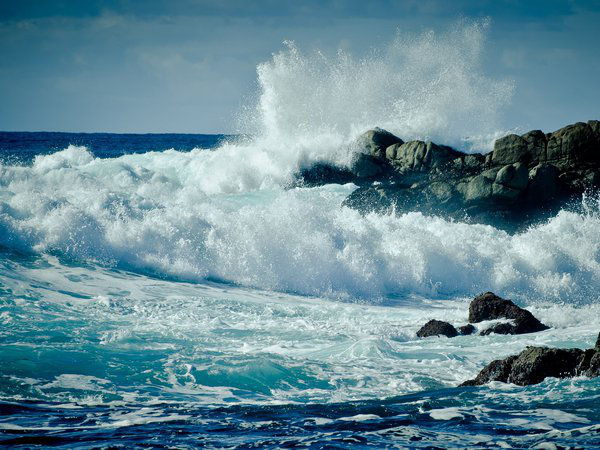

In [6]:
numpy2image(img_deep_dream)

In [7]:
#Пример как сделать forward до заданного слоя в resnet
net = models.resnet34(pretrained=True)

def my_forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)

    return x

in_img = torch.from_numpy(img_deep_dream).transpose(2,1).transpose(1,0).float()
in_img = Variable(trans(in_img).unsqueeze(0), requires_grad=True)
my_forward(net, in_img);

In [8]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
net = models.alexnet(pretrained=True)

net.to('cpu')

in_img = torch.from_numpy(img_deep_dream).transpose(2,1).transpose(1,0).float() 
in_img = Variable(trans(in_img).unsqueeze(0), requires_grad=True)


In [10]:
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Задание 1
#### Применить всю сеть без fullconnected слоев (должны получить лица животных и что-то визуально внятное)

In [11]:
def my_forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    return x

Iter 99


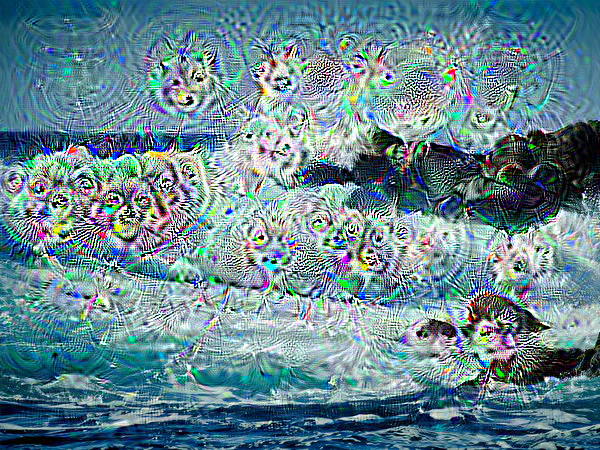

In [12]:
img = copy.deepcopy(img_deep_dream)

max_jitter = 32
step_size = 0    
TRACE_ITER = 15
for iter_id in range(100):

    shift_x, shift_y = np.random.randint( -max_jitter, max_jitter + 1, 2)
    img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)

    in_img = torch.from_numpy(img).transpose(2,1).transpose(1,0).float()
    in_img = Variable(trans(in_img).unsqueeze(0), requires_grad=True) # тут нам нужен будет градиент
    
    #forward до нужного слоя
    out = my_forward(net, in_img)
    #backward dx=x
    out.backward(gradient = out.data, retain_graph=True)

    grad = in_img.grad.data
    grad = grad[0, :, :, :]
    grad =  grad.transpose(0,1).transpose(1,2).numpy() #превращаем градиент в numpy 

    #обновление картинки img
    img += grad * 1e-3

    img = np.roll(np.roll(img, -shift_x, -1), -shift_y, -2)
    img = np.clip(img, 0, 1)

    if iter_id % TRACE_ITER == 0: 
        clear_output(True)
        print("Iter %d" % iter_id)
        display(numpy2image(img))
        print()

clear_output(True)
print("Iter %d" % iter_id)
display(numpy2image(img))
print()

## Задание 2

#### Сделать deep dream по нижним слоям (после 1-2 конволюций) - должы закрасить некоторой текстурой картинку в итоге

In [13]:
def my_forward(self, x):
    x = self.features[0:6](x)
    return x

Iter 99


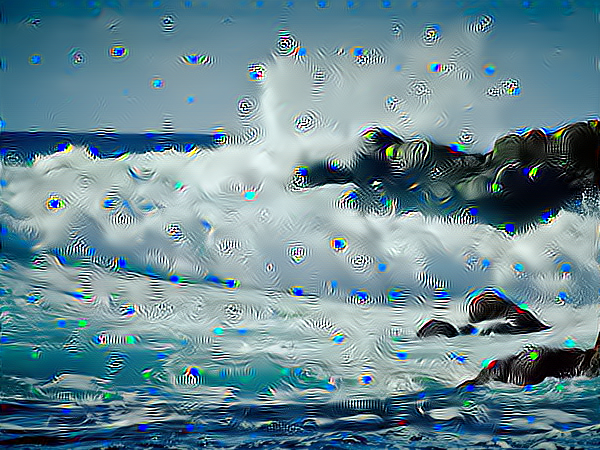

In [14]:
img = copy.deepcopy(img_deep_dream)

max_jitter = 32
step_size = 0    
TRACE_ITER = 25
for iter_id in range(100):

    shift_x, shift_y = np.random.randint( -max_jitter, max_jitter + 1, 2)
    img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)

    in_img = torch.from_numpy(img).transpose(2,1).transpose(1,0).float()
    in_img = Variable(trans(in_img).unsqueeze(0), requires_grad=True) # тут нам нужен будет градиент
    
    #forward до нужного слоя
    out = my_forward(net, in_img)
    #backward dx=x
    out.backward(gradient = out.data, retain_graph=True)

    grad = in_img.grad.data
    grad = grad[0, :, :, :]
    grad =  grad.transpose(0,1).transpose(1,2).numpy() #превращаем градиент в numpy 

    #обновление картинки img
    img += 1e-5 * grad / np.abs(np.mean(grad))

    img = np.roll(np.roll(img, -shift_x, -1), -shift_y, -2)
    img = np.clip(img, 0, 1)

    if iter_id % TRACE_ITER == 0:
        clear_output(True)
        print("Iter %d" % iter_id)
        display(numpy2image(img))
        print()
        
clear_output(True)
print("Iter %d" % iter_id)
display(numpy2image(img))
print()

## Задание 3
#### Сделать deep dream по средним слоям - должы закрасить некоторыми осмысленными узорами картинку в итоге

In [15]:
def my_forward(self, x):
    x = self.features[0:9](x)
    return x

Iter 99


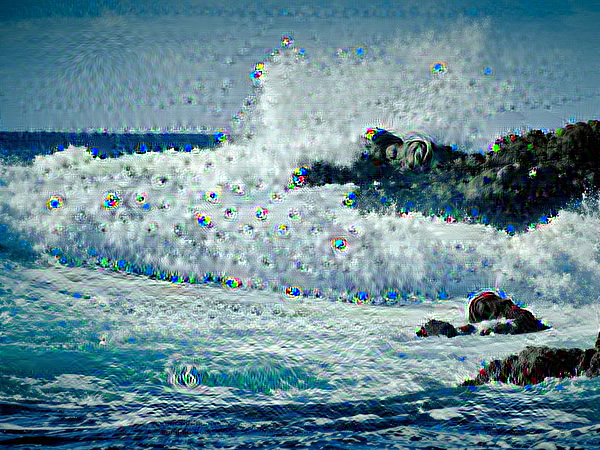

In [16]:
img = copy.deepcopy(img_deep_dream)

max_jitter = 32
step_size = 0    
TRACE_ITER = 25
for iter_id in range(100):

    shift_x, shift_y = np.random.randint( -max_jitter, max_jitter + 1, 2)
    img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)

    in_img = torch.from_numpy(img).transpose(2,1).transpose(1,0).float()
    in_img = Variable(trans(in_img).unsqueeze(0), requires_grad=True) # тут нам нужен будет градиент
    
    #forward до нужного слоя
    out = my_forward(net, in_img)
    #backward dx=x
    out.backward(gradient = out.data, retain_graph=True)

    grad = in_img.grad.data
    grad = grad[0, :, :, :]
    grad =  grad.transpose(0,1).transpose(1,2).numpy() #превращаем градиент в numpy 

    #обновление картинки img
    img += 1e-5 * grad / np.abs(np.mean(grad))

    img = np.roll(np.roll(img, -shift_x, -1), -shift_y, -2)
    img = np.clip(img, 0, 1)

    if iter_id % TRACE_ITER == 0:
        clear_output(True)

        print("Iter %d" % iter_id)
        display(numpy2image(img))
        print()
        
clear_output(True)
print("Iter %d" % iter_id)
display(numpy2image(img))
print()